In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

2023-03-19 23:21:29.333951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 23:21:30.522253: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-19 23:21:30.522369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-19 23:21:30.522381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bkapteijns/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bkapteijns/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/bkapteijns/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv("ecommerceDataset.csv", header=None)
print(np.sum(df[1].isna()))
df = df.dropna()
print(np.sum(df[1].isna()))
df.head()

1
0


,0,1
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


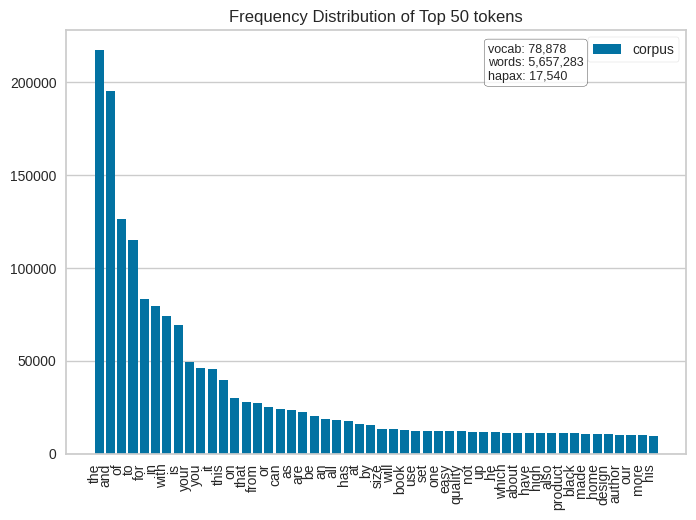

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [4]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df[1])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [5]:
text = df[1]
labels = df[0]

print(text.shape, labels.shape)

(50424,) (50424,)


In [6]:
text = text[(labels == "Books") | (labels == "Electronics")]
labels = labels[(labels == "Books") | (labels == "Electronics")]

print(text.shape, labels.shape)

(22441,) (22441,)


In [7]:
indices = []
for x in text:
    if (len(x.split(' ')) < 64):
        indices.append(True)
    else:
        indices.append(False)

text = text[indices]
labels = labels[indices]

In [8]:
# remove digits, @-mentions, links, stopwords
text = text.str.lower()
text = text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
text = text.apply(lambda x : nltk.word_tokenize(x))
text = text.apply(lambda x : " ".join([word for word in x if word not in nltk.corpus.stopwords.words()]))

text.shape

(8735,)

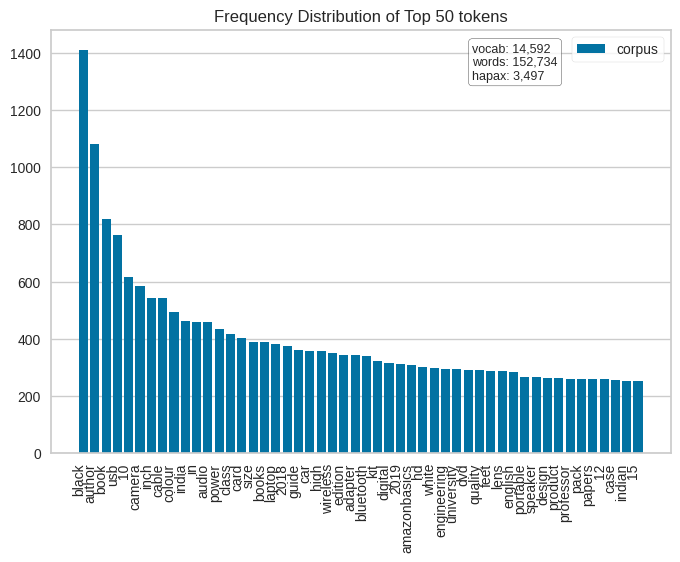

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [9]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(text)
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
labels = np.array(labels)
text = np.array(text)

In [12]:
lengths = []

X = text
for i in range(len(text)):
  X[i] = tokenizer.tokenize(X[i])
  X[i] = tokenizer.convert_tokens_to_ids(X[i])

for i in range(len(X)):
  lengths.append(len(X[i]))

In [13]:
lengths = np.array(lengths)
X = np.array(X)

print(lengths)
print(lengths.shape)
print(np.sum(lengths < 64) / len(lengths))
print(np.sum(lengths < 64))
print(np.sum((lengths < 64) & (labels == "Electronics")))
print(np.sum((lengths < 64) & (labels == "Books")))

[ 6 21 68 ... 35 18 10]
(8735,)
0.894791070406411
7816
2701
5115


In [14]:
X_electronics = X[(lengths < 64) & (labels == "Electronics")]
X_books = X[(lengths < 64) & (labels == "Books")]
X_new = X_electronics[:2000].tolist() + X_books[:2000].tolist()

y_electronics = labels[(lengths < 64) & (labels == "Electronics")]
y_books = labels[(lengths < 64) & (labels == "Books")]
y_new = y_electronics[:2000].tolist() + y_books[:2000].tolist()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_new), np.array(y_new), train_size=500, shuffle=True)

X_test = X_test[:50]
y_test = y_test[:50]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [16]:
import torch

model.config.max_position_embeddings = 64
max_length = model.config.max_position_embeddings

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [17]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0638, -0.3639, -0.2423,  ..., -0.3537,  0.8339, -0.3447],
         [-0.0507,  0.0778, -0.2453,  ..., -0.3554,  0.0048, -0.2069],
         [-0.0493,  0.2603, -0.6791,  ..., -0.4547, -0.0717, -0.3441],
         ...,
         [-0.0165, -0.5262,  0.1770,  ..., -0.4743,  0.8720, -0.5254],
         [-0.0126, -0.5364,  0.1796,  ..., -0.4608,  0.8835, -0.5367],
         [ 0.0178, -0.5540,  0.1341,  ..., -0.4514,  0.8811, -0.5607]],

        [[ 0.1808, -0.1807, -0.3844,  ..., -0.3309,  0.4015, -0.3300],
         [-0.9678,  0.2055,  0.6334,  ..., -0.5580,  0.0525, -0.3157],
         [-0.4290,  0.6898,  0.4385,  ..., -0.4315, -0.0334,  0.1418],
         ...,
         [ 0.5978, -0.1449, -0.1687,  ..., -0.4069,  0.4988, -0.2948],
         [ 0.6015, -0.1103, -0.1457,  ..., -0.4156,  0.5073, -0.3111],
         [ 0.6214, -0.0849, -0.1884,  ..., -0.4241,  0.5001, -0.3427]],

        [[ 0.0857, -0.1605,  0.3980,  ..., -0.4234,  

In [18]:
bert_train_output = bert_train_output[1].detach().numpy().copy()
bert_train_output = bert_train_output.reshape(X_train.shape[0], 768)

In [19]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2222, -0.1970,  0.4241,  ..., -0.4691,  0.5741,  0.2278],
         [-0.0596,  0.2414,  0.7467,  ..., -0.2708,  0.4054,  0.0848],
         [ 0.2451,  0.3917,  0.6531,  ..., -0.1608,  0.3528, -0.1621],
         ...,
         [-0.2372, -0.2642,  0.3259,  ..., -0.8166,  0.3684,  0.0549],
         [-0.2468, -0.2515,  0.3222,  ..., -0.8134,  0.3914,  0.0541],
         [-0.2385, -0.2078,  0.3334,  ..., -0.8279,  0.3641,  0.0322]],

        [[-0.3659, -0.2101,  0.1576,  ..., -0.5680,  0.3891,  0.1011],
         [-0.3193,  0.2485,  0.0757,  ..., -0.3147,  0.3052, -0.0719],
         [-0.3772,  0.3895,  0.1794,  ..., -0.2867,  0.2866, -0.2845],
         ...,
         [-0.3879, -0.4780,  0.2350,  ..., -0.6119,  0.5713, -0.0655],
         [-0.3822, -0.4849,  0.2269,  ..., -0.6069,  0.5892, -0.0533],
         [-0.3712, -0.4719,  0.2069,  ..., -0.6136,  0.5755, -0.0552]],

        [[ 0.2333, -0.2510,  0.5328,  ..., -0.1615,  

In [20]:
bert_test_output = bert_test_output[1].detach().numpy().copy()
bert_test_output = bert_test_output.reshape(X_test.shape[0], 768)

In [21]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [22]:
clf = neural_network.MLPClassifier()
clf.fit(bert_train_output, le.transform(y_train))

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


MLPClassifier()

In [23]:
print("Train accuracy:", np.mean(clf.predict(bert_train_output) == le.transform(y_train)))
print("Test accuracy:", np.mean(clf.predict(bert_test_output) == le.transform(y_test)))

Train accuracy: 0.986
Test accuracy: 0.86


In [24]:
print(np.unique(y_test))

['Books' 'Electronics']


In [25]:
np.mean(y_test=="Electronics")

0.36

In [26]:
shap.initjs()

In [27]:
to_explain = np.array(X_test_padded)[:20]
to_explain.shape

(20, 64)

In [28]:
def prediction_model(X):
  bert_output = model(torch.from_numpy(np.array(X)).to(torch.int64))
  sequence_output = bert_output[1].detach().numpy()
  return clf.predict(sequence_output.reshape(X.shape[0], 768))

In [29]:
permutation_values = []
permutation_explainer = shap.explainers.Permutation(prediction_model, np.array(to_explain))
for i in range(len(to_explain)):
  permutation_values.append(permutation_explainer(np.array([to_explain[i]])))

Permutation explainer: 2it [03:06, 186.78s/it]                                                                                        
Permutation explainer: 2it [02:23, 143.62s/it]                                                                                        
Permutation explainer: 2it [03:27, 207.93s/it]                                                                                        
Permutation explainer: 2it [02:42, 162.47s/it]                                                                                        
Permutation explainer: 2it [03:02, 182.76s/it]                                                                                        
Permutation explainer: 2it [02:40, 160.27s/it]                                                                                        
Permutation explainer: 2it [06:00, 360.75s/it]                                                                                        
Permutation explainer: 2it [04:29, 269.29s/it]         

In [30]:
permutation_values

[.values =
 array([[-5.62500000e-02,  1.87500000e-02, -2.50000000e-02,
          2.50000000e-02,  6.25000000e-03, -6.25000000e-03,
          1.25000000e-02,  1.73472348e-18, -1.25000000e-02,
          0.00000000e+00, -6.25000000e-03, -6.25000000e-03,
         -1.73472348e-18, -1.25000000e-02, -1.25000000e-02,
         -6.25000000e-03, -1.87500000e-02, -2.50000000e-02,
         -1.25000000e-02, -1.87500000e-02, -6.25000000e-03,
         -3.75000000e-02, -6.25000000e-03, -6.25000000e-03,
         -6.25000000e-03, -6.25000000e-03, -6.25000000e-03,
          6.25000000e-03, -6.25000000e-03,  1.25000000e-02,
         -1.87500000e-02,  6.25000000e-03,  0.00000000e+00,
         -1.25000000e-02,  0.00000000e+00,  6.25000000e-03,
         -3.75000000e-02,  0.00000000e+00,  1.87500000e-02,
          0.00000000e+00,  0.00000000e+00, -6.25000000e-03,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          6.25000000e-03,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.

In [31]:
perm_vals = {"values": [], "base_values": [], "data": []}
for pv in permutation_values:
    perm_vals["values"].append(pv.values[0])
    perm_vals["base_values"].append(pv.base_values[0])
    perm_vals["data"].append(pv.data[0])

Sentence: society minute tea , mas ##ala , 140 ##g flavour ##ed tea , mix aromatic indian spices favourite millions indians . enjoying special cha ##i instantly ? . minute . ; Prediction: [0] ; True value: Books


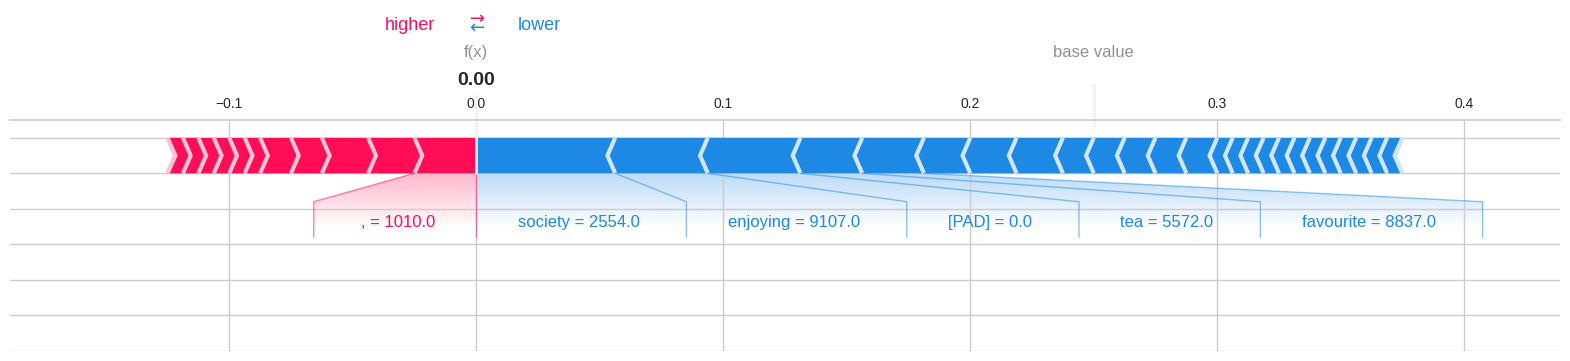

Sentence: general studies - paper civil services preliminary examination ( 2019 ) ; Prediction: [0] ; True value: Books


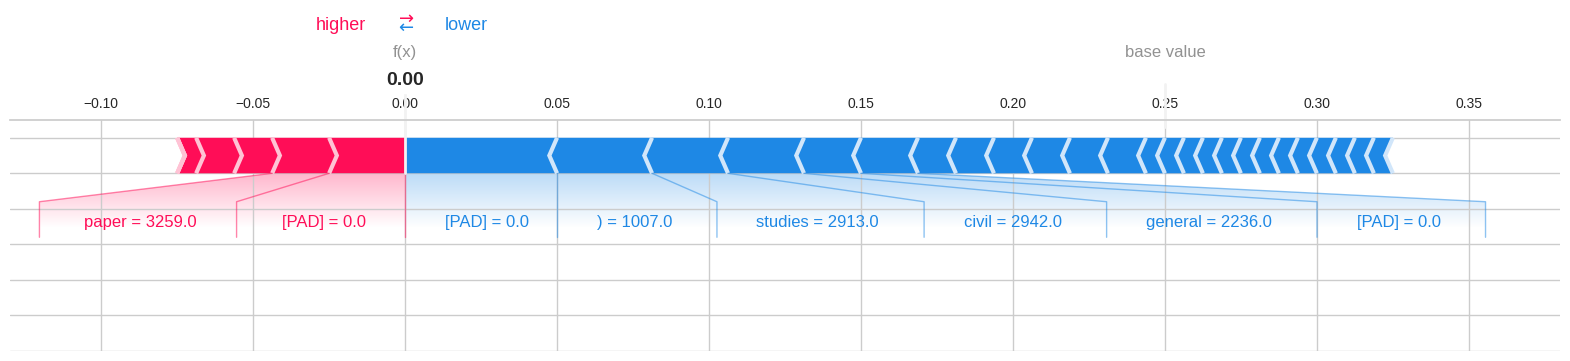

Sentence: pt ##e academic practice test vol . 1 2 combo 50 % discount official online gold test preparation kit author developers pt ##e academic test . ; Prediction: [0] ; True value: Books


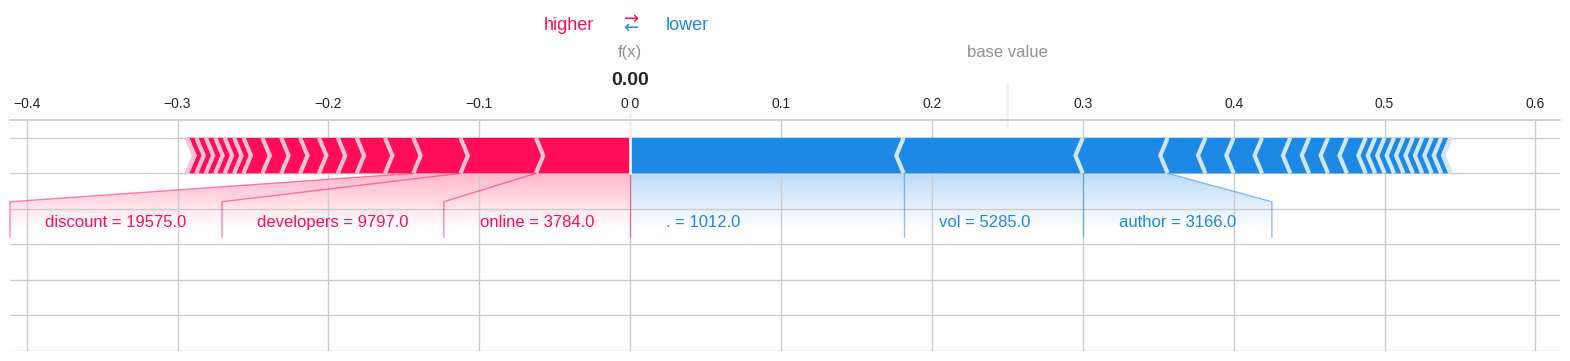

Sentence: biography : dh ##ir ##ub ##hai am ##ban ##i ; Prediction: [0] ; True value: Books


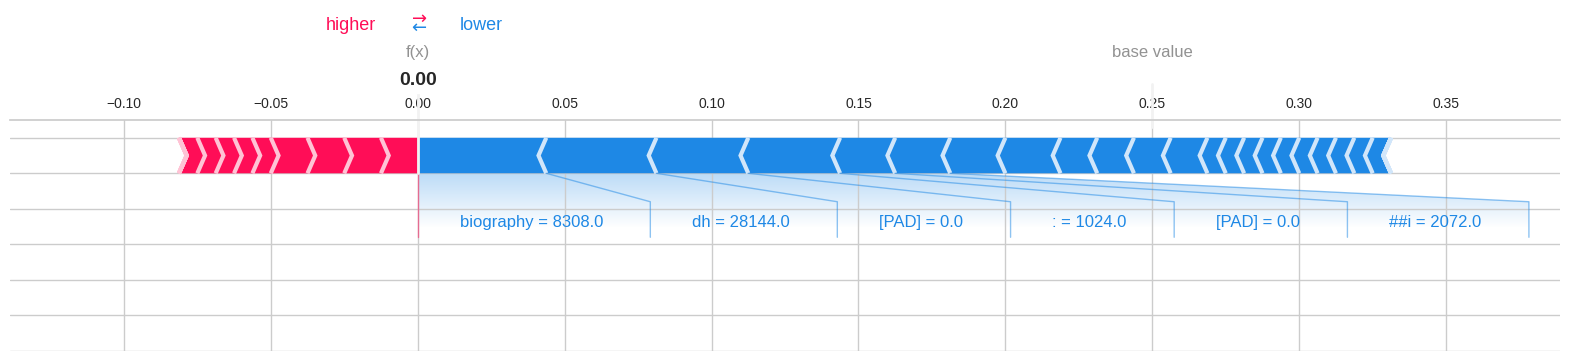

Sentence: fry ##master 81 ##3 - 00 ##35 bronze bun ##ting bush ##ing fry ##master llc 81 ##30 ##0 ##35 bronze bush ##ing ; Prediction: [0] ; True value: Electronics


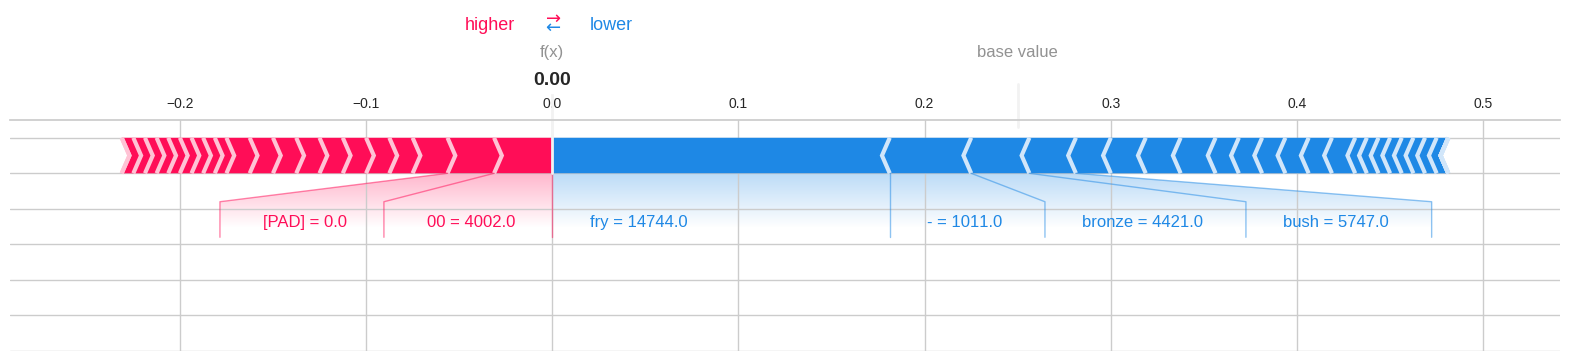

Sentence: rr ##b study guide 2019 stage 1 ( hindi ) ; Prediction: [0] ; True value: Books


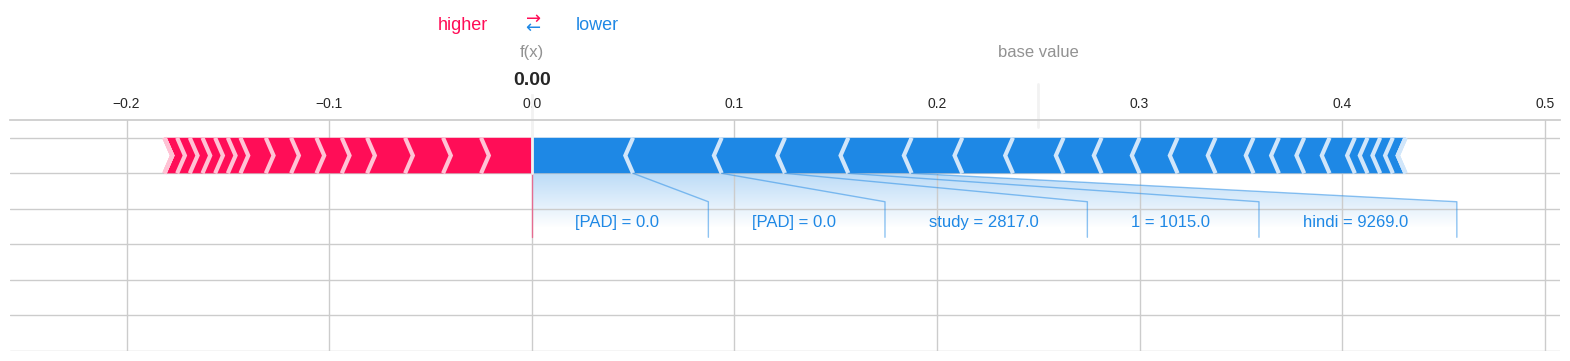

Sentence: clinical medicine ( textbook clinical methods laboratory investigations ) ( textbook clinical methods & laboratory investigations ) author kv krishna bsc fr ##cp ( ) fa ##ms dt ##m ( ed ##in ) consultant physician ha ##ema ##to ##logist , retired director professor medicine , medical college , tri ##van ##drum , kerala , india ; Prediction: [0] ; True value: Books


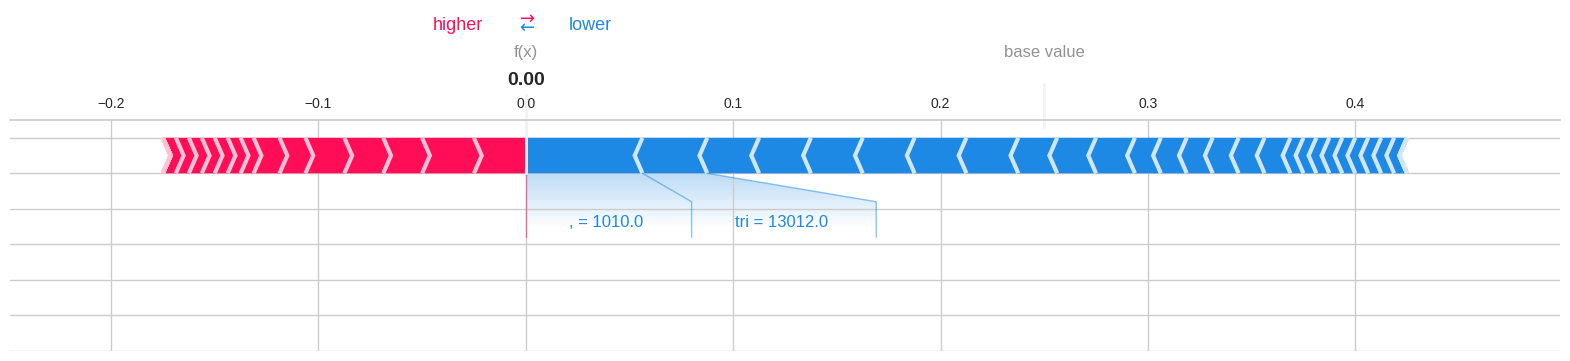

Sentence: d - link dh ##p - 60 ##1 ##av power ##line av ##2 1000 gig ##abi ##t starter kit brand : d - link , d - link power ##line av ##2 1000 gig ##abi ##t starter kit ( dh ##p - 60 ##1 ##av ) ; Prediction: [1] ; True value: Electronics


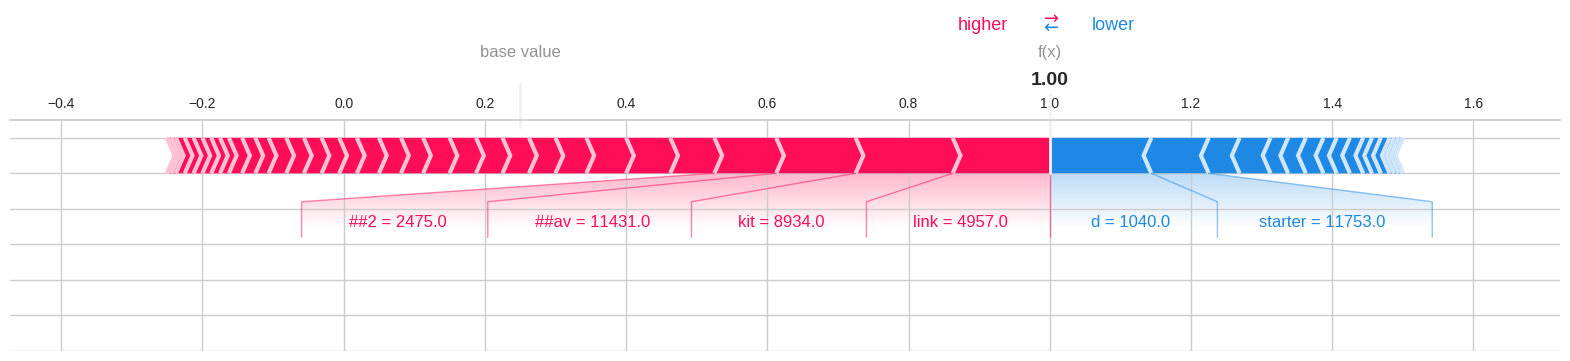

Sentence: elect ##oman ##ia hi - fi stereo audio mini amplifier ( silver ) car motorcycle mp3 mp ##4 hi - fi stereo audio mini amplifier 12 ##v 2a . adopting integrated circuit design advanced 45 ##58 chip . ; Prediction: [1] ; True value: Electronics


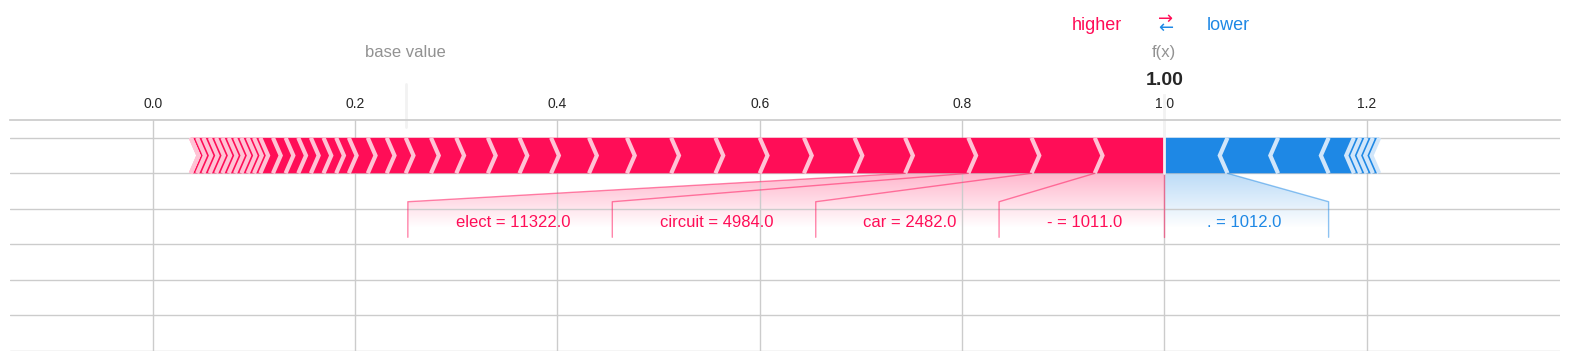

Sentence: capital twenty - first century ; Prediction: [0] ; True value: Books


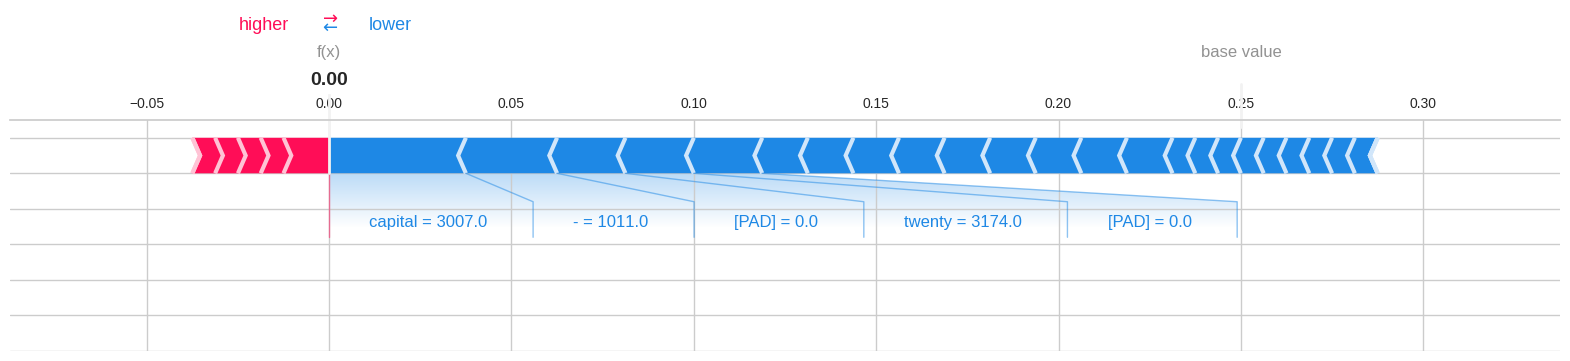

Sentence: introducing physical geography , 6 ##ed ; Prediction: [0] ; True value: Books


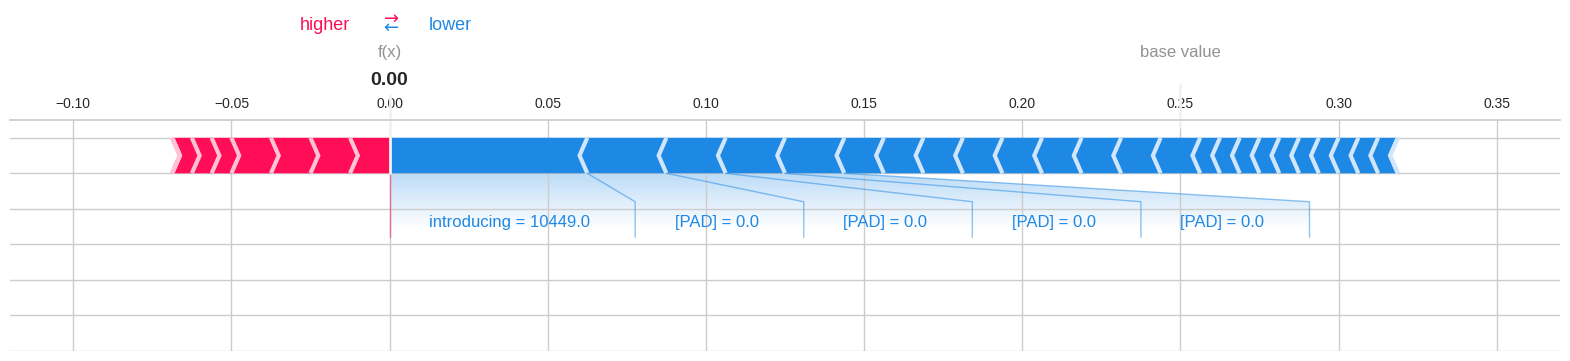

Sentence: o ##oz ##e pun ##nk ##k p ##7 full hd led home theater project ##or ( black ) o ##oz ##e pun ##nk ##k p ##7 finest home entertainment project ##or pun ##nk ##k . pick warrant ##y 2 years . ; Prediction: [1] ; True value: Electronics


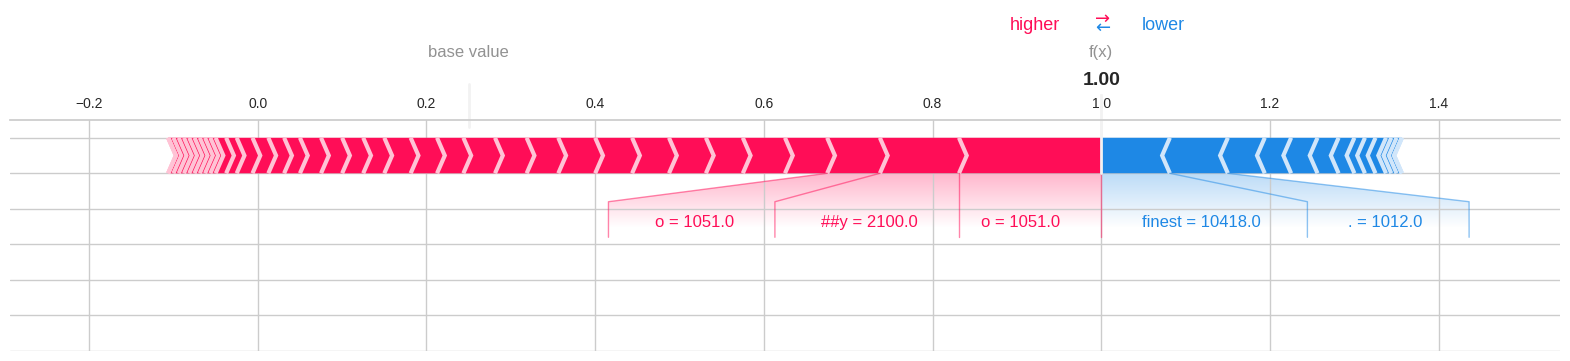

Sentence: web ##cam hd 43 ##10 * * retail * * web ##cam hd 43 ##10 * * retail * * ; Prediction: [0] ; True value: Electronics


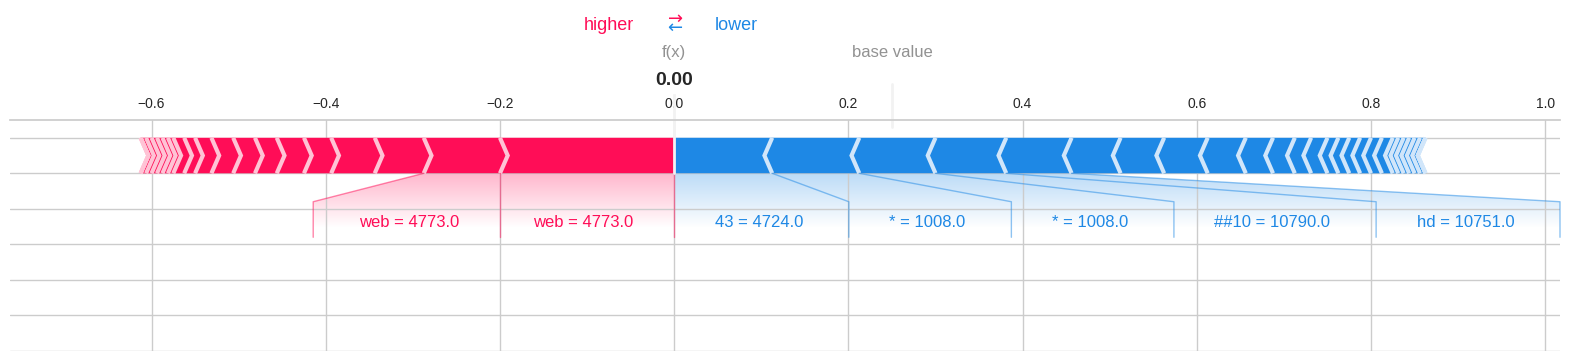

Sentence: learn kannada 30 days author author : krishna go ##pal vi ##kal author similar books languages learn malayalam 30 days english , learn tamil 30 days english , learn gujarati 30 days english learn hindi 30 days english . ; Prediction: [0] ; True value: Books


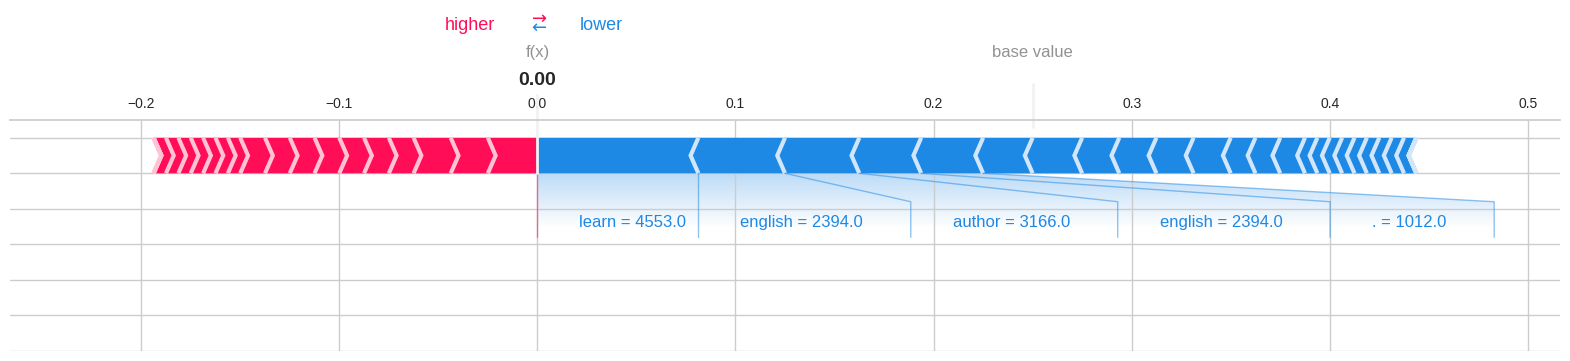

Sentence: tin ##kle digest ( 1980 - 2008 ) : pack 10 pack includes 10 tin ##kle digest series . ; Prediction: [1] ; True value: Books


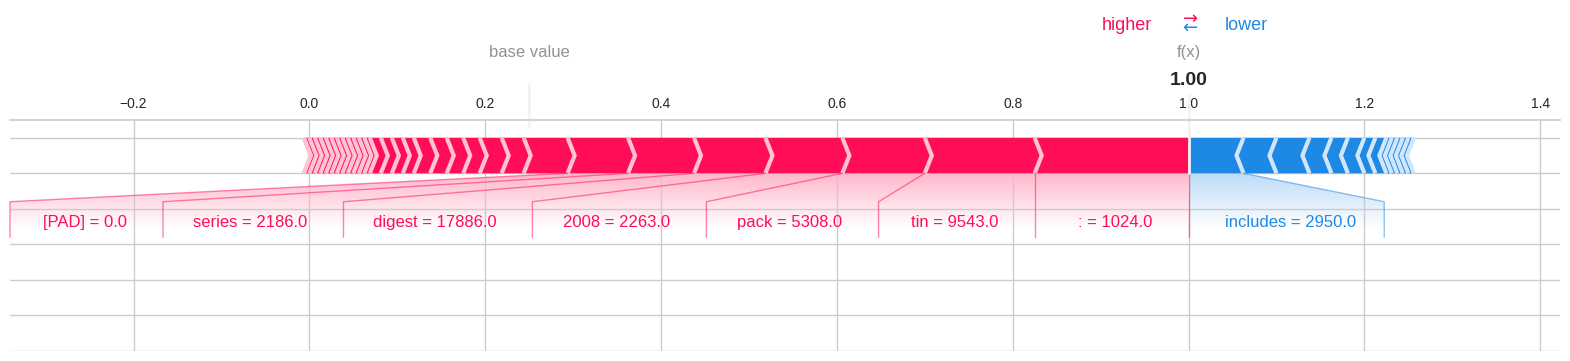

Sentence: introduction social anthropology introduction social anthropology ; Prediction: [0] ; True value: Books


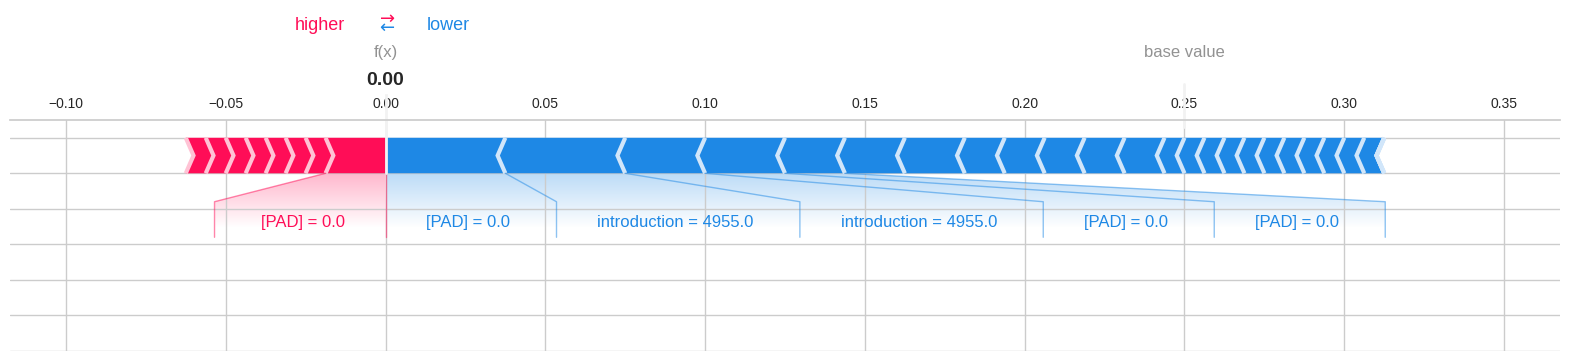

Sentence: learn french 30 days book : learn french 30 days through ##eng ##lish indian learn languages - english to ##con ##ta ##ct world , hindi contact entire india regional ##lang ##ua ##ge person lives . fact , learn more ##lang ##ua ##ges - maha ##tma gandhi ; Prediction: [0] ; True value: Books


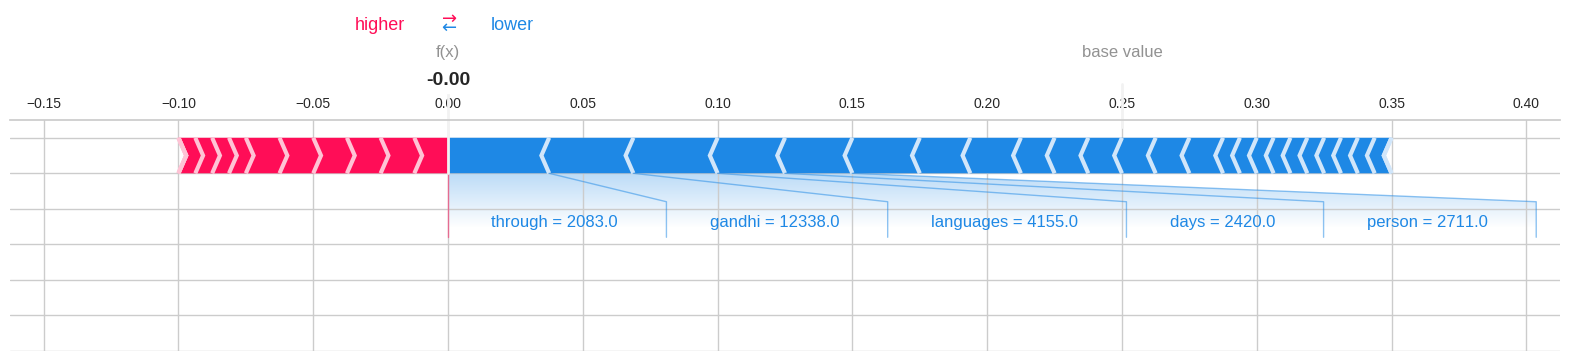

Sentence: golf putting instruction book ! ( book & dvd ) author golf magazine total readers ##hip 6 . 1 million . ; Prediction: [0] ; True value: Books


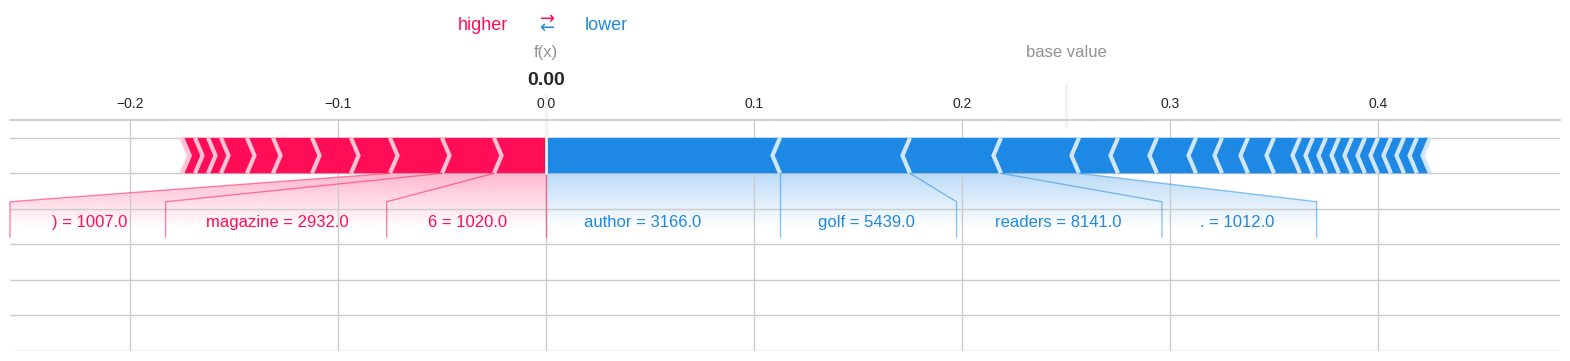

Sentence: general training student ' s book answers audio ; Prediction: [0] ; True value: Books


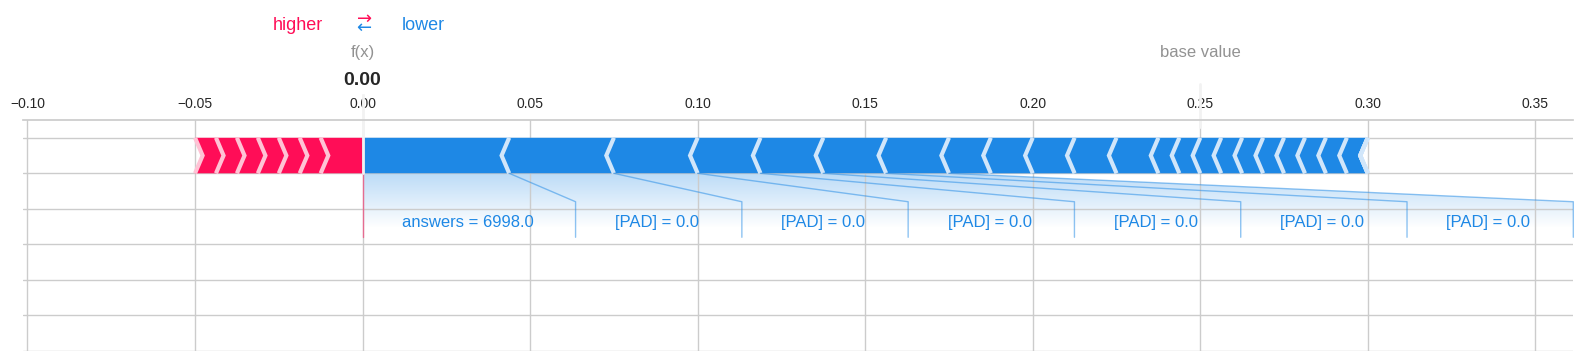

Sentence: eps ##on el ##pl ##p ##6 ##9 replacement project ##or lamp / bulb brand or ##ign ##al lamp ; Prediction: [1] ; True value: Electronics


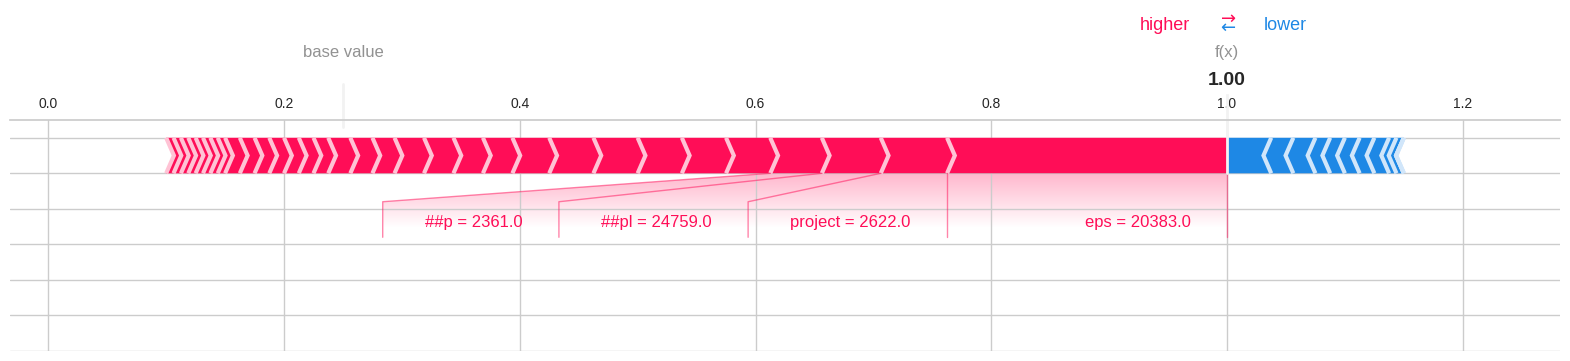

In [32]:
for i in range(len(to_explain)):
  print("Sentence:", " ".join(tokenizer.convert_ids_to_tokens(to_explain[i])).replace(" [PAD]", "") ,"; Prediction:", prediction_model(np.array([to_explain[i]])), "; True value:", y_test[i])
  shap.plots.force(perm_vals["base_values"][i], perm_vals["values"][i], perm_vals["data"][i], feature_names=tokenizer.convert_ids_to_tokens(perm_vals["data"][i]), matplotlib=True)

In [33]:
import copy
heatmaps = np.array(copy.copy(perm_vals["values"]))
heatmaps += perm_vals["base_values"][0]/64
for i in range(len(heatmaps)):
  print(np.sum(heatmaps[i]))

-2.42861286636753e-17
-2.0816681711721685e-17
4.163336342344337e-17
-1.3877787807814457e-17
4.163336342344337e-17
-1.3877787807814457e-17
-1.9081958235744878e-17
1.0
1.0
3.469446951953614e-18
1.3877787807814457e-17
0.9999999999999999
2.0816681711721685e-17
1.3877787807814457e-17
0.9999999999999999
3.469446951953614e-17
1.3877787807814457e-17
-2.0816681711721685e-17
-5.204170427930421e-18
1.0


Prediction: Books


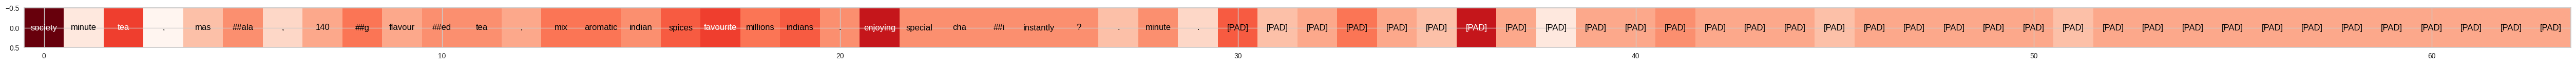

Prediction: Books


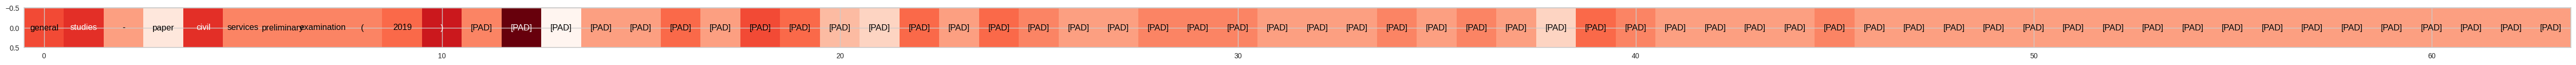

Prediction: Books


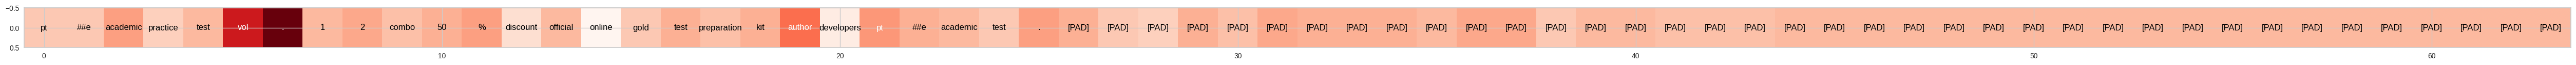

Prediction: Books


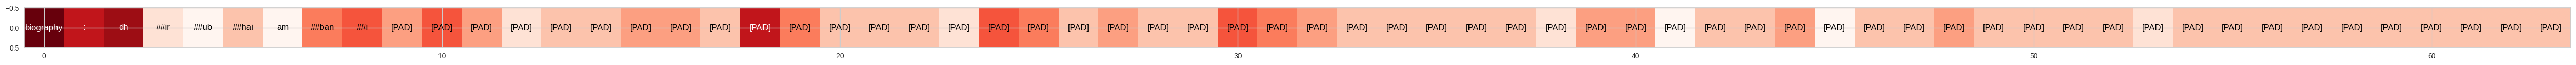

Prediction: Books


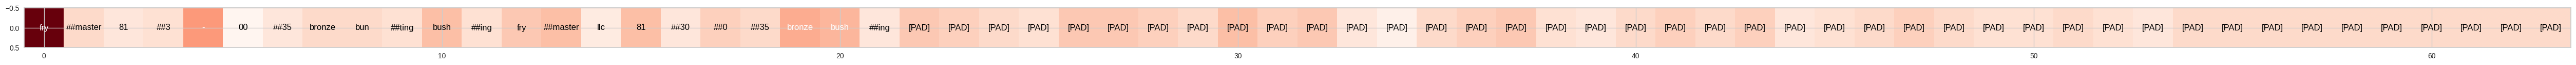

Prediction: Books


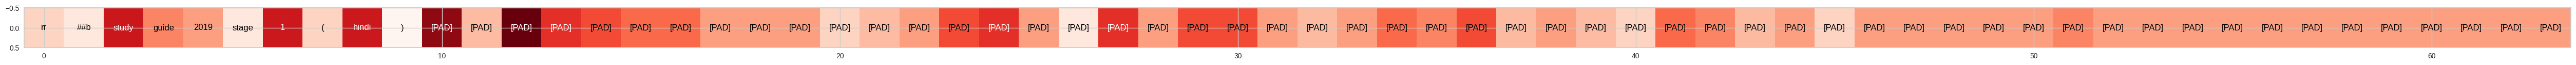

Prediction: Books


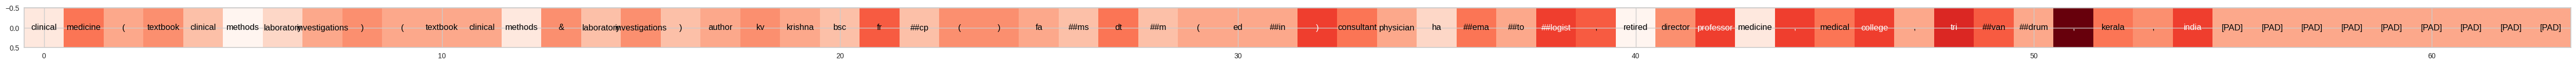

Prediction: Electronics


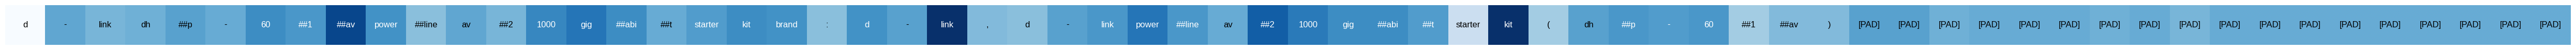

Prediction: Electronics


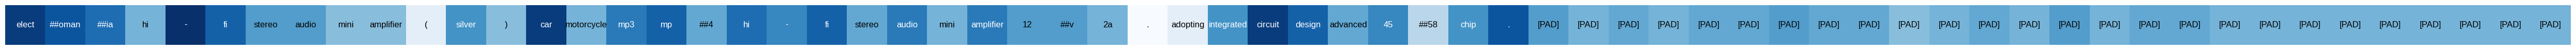

Prediction: Books


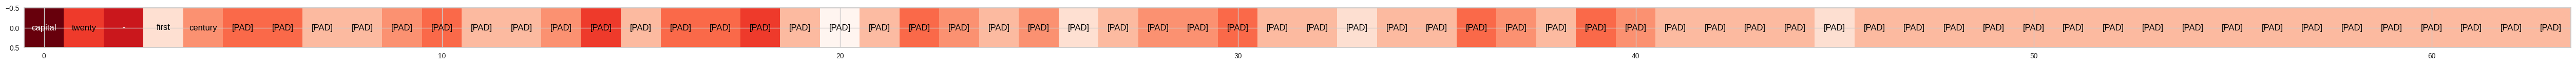

Prediction: Books


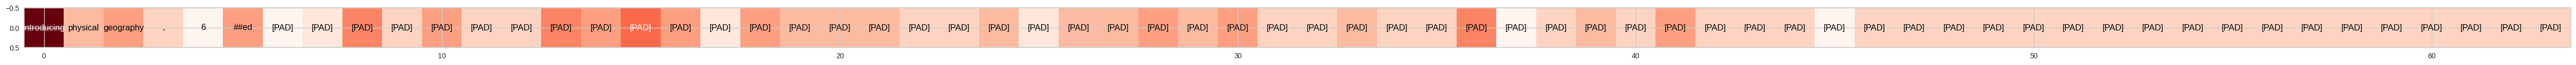

Prediction: Electronics


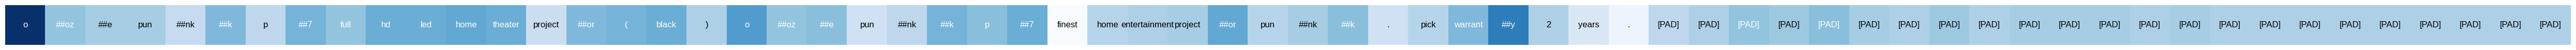

Prediction: Books


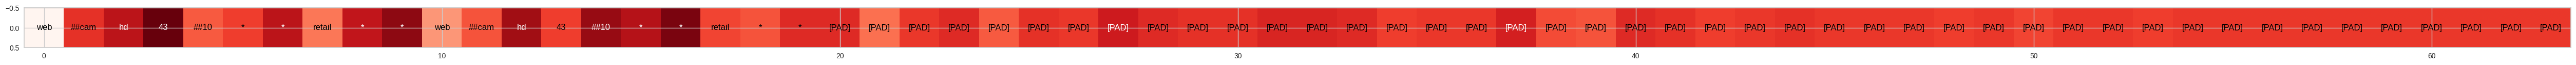

Prediction: Books


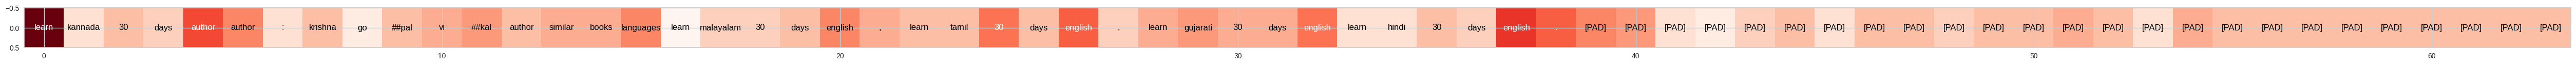

Prediction: Electronics


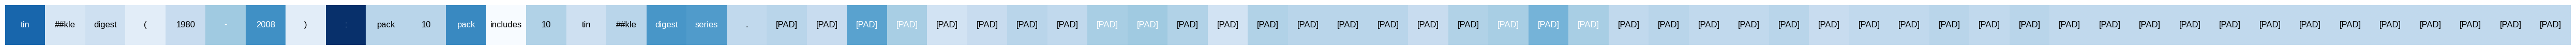

Prediction: Books


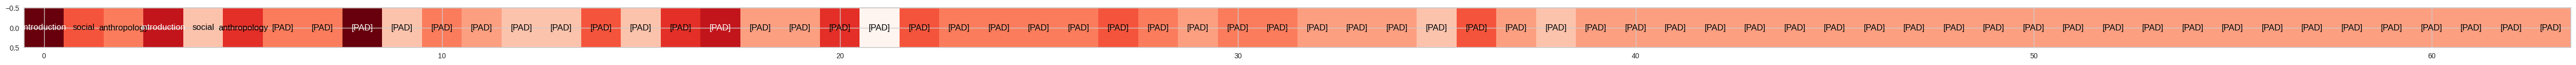

Prediction: Books


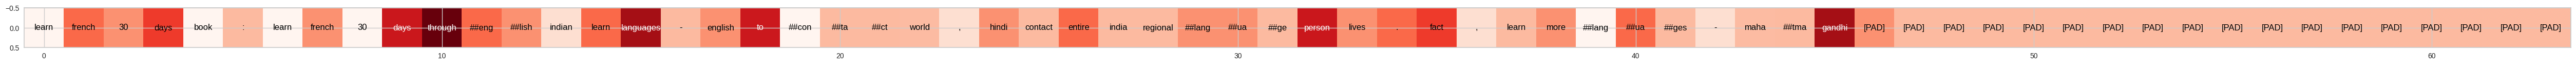

Prediction: Books


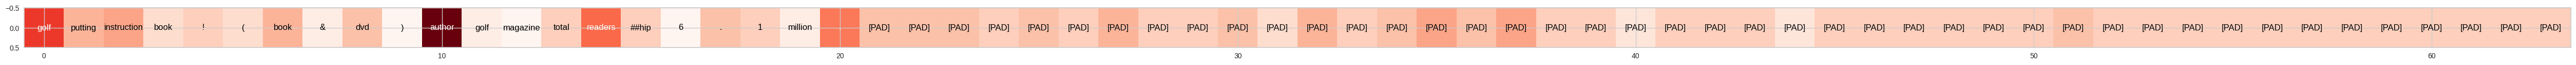

Prediction: Books


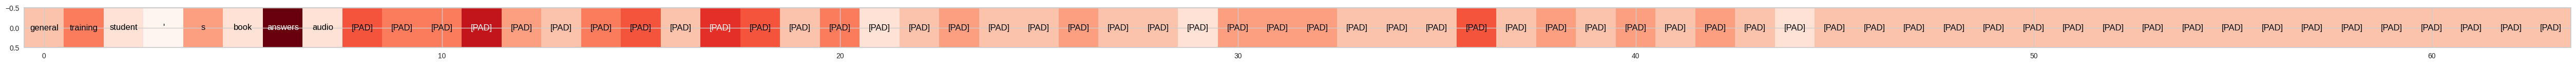

Prediction: Electronics


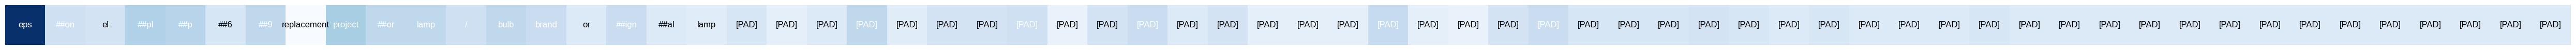

In [34]:
for x in range(len(to_explain)):
  fig, ax = plt.subplots(figsize=(len(to_explain[x]), 1))
  if prediction_model(np.array([to_explain[x]]))[0] == 0:
    print("Prediction: Books")
    ax.imshow([-heatmaps[x]], cmap="Reds", aspect="auto")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] < -0.02 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))
  else:
    print("Prediction: Electronics")
    ax.imshow([heatmaps[x]], cmap="Blues", aspect="auto")
    ax.axis("off")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] > 0.02 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))


  plt.show()

In [35]:
def ablate(x, i):
  x[i] = 0
  for j in range(i, len(x)-1):
    x[j] = x[j+1]
  x[-1] = 0
  return x
def compute_contrast(X, model, explanation):
  contrast = [0]*len(X)
  for i in range(len(X)):
    old_prediction = model(np.array([X[i]]))
    for j in range(len(X[i])):
      x = ablate(copy.deepcopy(X[i]), j)
      new_prediction = model(np.array([x]))
      if (new_prediction != old_prediction):
        contrast[i] += explanation[i][j]
  return contrast

In [36]:
def compute_distinctiveness(data, train_data, explanation):
  distinctiveness = [0] * len(data)

  frequencies = []
  for x in np.unique(train_data):
    frequencies.append((np.mean(np.array(train_data) == x), x))
  sorted_frequencies = sorted(frequencies)
  word_specialty = {0: 0}
  for i, (f, x) in enumerate(sorted_frequencies):
    word_specialty[x] = 1 - i / len(sorted_frequencies)

  for i in range(len(data)):
    for j in range(len(data[i])):
      try:
        distinctiveness[i] += word_specialty[data[i][j]] * explanation[i][j]
      except:
        distinctiveness[i] += explanation[i][j]

  return distinctiveness

In [37]:
def compute_fidelity(X, explanation, model):
    fidelity = [0] * len(X)
    samples = 5
    for i in range(len(X)):
        change_ratings = [0]*len(X[i])
        x = 0
        while x < len(X[i]):
            print(x)
            change_rating = 0
            for change in range(samples):
                new_X = copy.deepcopy(X[i])
                new_X[x] = new_X[x] + (100 * change / samples)
                if (model(np.array([X[i]])) == model(np.array([new_X]))):
                    change_rating += 1/samples
            change_ratings[x] = change_rating
            if (X[i][x] == 0):
                x = len(X[i])
            x += 1
            
        for j in range(len(X[i])):
            fidelity[i] += change_ratings[j] * explanation[i][j]
    return fidelity

In [38]:
from nltk.corpus import wordnet as wn
def compute_realism(data, id_to_token, topic, explanation):
  """
  data: the word ids in the shape of #elements x #words
  topic: a wordnet synset
  id_to_token: a function from ids to tokens

  returns an array of length #elements
  """
  metrics = [0] * len(data)
  for i in range(len(data)):
    for j in range(len(data[i])):
      try:
        metrics[i] += explanation[i][j] * topic.wup_similarity(wn.synsets(id_to_token([data[i][j]])[0])[0])
      except:
        pass
  return metrics

In [39]:
def explanation_converter(explanations):
  new_explanations = []
  for i in range(len(explanations)):
    if (np.sum(explanations[i]) > 0):
      new_explanations.append(explanations[i] + (1 - np.sum(explanations[i]))/64)
    else:
      new_explanations.append(-explanations[i] + (1 + np.sum(explanations[i]))/64)
  return new_explanations
standardized_explanations = explanation_converter(perm_vals["values"])

In [40]:
for x in standardized_explanations:
  print(np.sum(x))
print(standardized_explanations)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
[array([ 0.06796875, -0.00703125,  0.03671875, -0.01328125,  0.00546875,
        0.01796875, -0.00078125,  0.01171875,  0.02421875,  0.01171875,
        0.01796875,  0.01796875,  0.01171875,  0.02421875,  0.02421875,
        0.01796875,  0.03046875,  0.03671875,  0.02421875,  0.03046875,
        0.01796875,  0.04921875,  0.01796875,  0.01796875,  0.01796875,
        0.01796875,  0.01796875,  0.00546875,  0.01796875, -0.00078125,
        0.03046875,  0.00546875,  0.01171875,  0.02421875,  0.01171875,
        0.00546875,  0.04921875,  0.01171875, -0.00703125,  0.01171875,
        0.01171875,  0.01796875,  0.01171875,  0.01171875,  0.01171875,
        0.00546875,  0.01171875,  0.01171875,  0.01171875,  0.01171875,
        0.01171875,  0.00546875,  0.01171875,  0.01171875,  0.01171875,
        0.01171875,  0.01171875,  0.01171875,  0.01171875,  0.01171875,
        0.01171875,  0.01171875,  0.0117

In [41]:
contrast = compute_contrast(to_explain, prediction_model, standardized_explanations)
print(contrast)

[0, 0, 0.32343750000000004, 0, 0.19296874999999997, 0.011718749999999998, 0, 0, 0, 0, 0, 0.003906250000000016, 0.546875, 0.09296875, 0.33515625000000004, 0, 0, 0, 0, 0.24140625000000004]


In [42]:
distinctiveness = compute_distinctiveness(to_explain, X_train_padded, standardized_explanations)
print(distinctiveness)

[0.28243598225404687, 0.05731485445205486, 0.11801253113325019, 0.14164510040473258, 0.3723823746886673, 0.007725180962017426, 0.3895545512920296, 0.2824829253580326, 0.22684659090909107, 0.0787068026151928, 0.0801355269302613, 0.09014827210460771, 0.31149595267745933, 0.12843341376089681, 0.2373659810865506, 0.0260619357098381, 0.44054424813200466, 0.06813365893524267, 0.022642629202988786, 0.1802379261363638]


In [43]:
realism = compute_realism(to_explain, tokenizer.convert_ids_to_tokens, wn.synset("good.n.01"), standardized_explanations)
print(realism)

[0.10131184124290742, 0.030957805819696302, 0.029981950111775478, 0.014583333333333334, 0.058034620098039204, 0.031761553780165916, 0.06648881760868992, 0.19059635893620266, 0.1069675281060851, 0.031141826923076925, 0.019370039682539683, 0.09824528769841273, -0.033401988636363636, 0.1426199975728928, 0.09340678418803419, 0.03953431372549018, 0.12103833436783805, 0.061804017786264306, 0.03451773168781683, 0.031468387234701564]


In [44]:
fidelity = compute_fidelity(to_explain, standardized_explanations, prediction_model)
print(fidelity)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0
1
2
3
4
5
6
7
8